# Pneumonia labelization

This notebook will work on given dataset and try to retreive class properly previously adapted data

**Main goals are**: 

    - Put labels above images
    - Prepare data so it is easier to read (separated csv)

Normal
         Pixel_Value  class
0                  0      0
1                 29      0
2                 34      0
3                 33      0
4                 35      0
...              ...    ...
2911995           35      0
2911996           35      0
2911997           36      0
2911998           31      0
2911999            0      0

[2912000 rows x 2 columns]


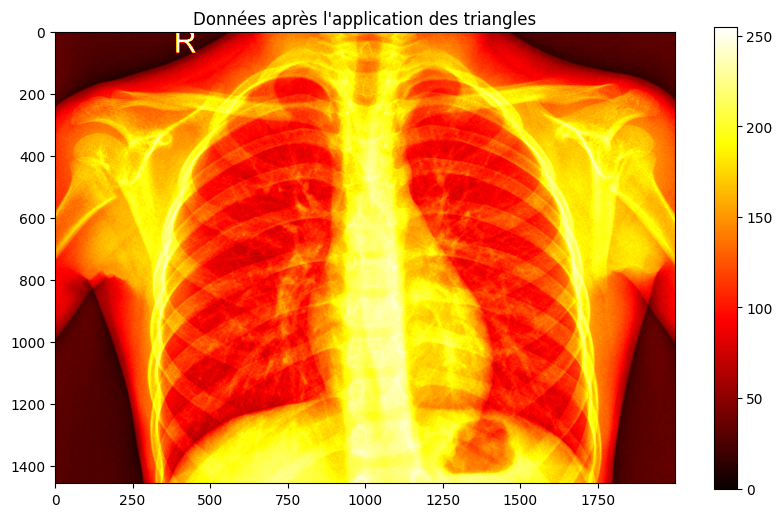

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

dfs_folder = "../../datasets/chest_Xray/local_test/_processed_resize/_processed_dfs"

dfs_files = [f for f in os.listdir(dfs_folder) if os.path.isfile(os.path.join(dfs_folder, f))]
    

for df_file in dfs_files:
    df = pd.read_csv(os.path.join(dfs_folder, df_file))
    if "bacteria" in df_file:
        print("Bacteria")
        df['class'] = 2
    elif "virus" in df_file:
        print("Virus")
        df['class'] = 1
    else:
        print("Normal")
        df['class'] = 0

    print(df)
    result = df["Pixel_Value"].values.reshape(1456, 2000)
    plt.figure(figsize=(10, 6))
    plt.imshow(result, cmap='hot')
    plt.colorbar()
    plt.title('Données après l\'application des triangles')
    plt.show()
    break



In [4]:
from datasets import load_dataset

dataset = load_dataset("Az-r-ow/chest_xray")

c:\Users\chapu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 5216
})

In [9]:
import numpy as np
from PIL import Image

# Open the image file
image = dataset["train"][0]["image"]

# Convert the image to grayscale
image_gray = image.convert('L')

# Convert the grayscale image to a NumPy array
image_array = np.array(image_gray)

# Display the shape of the array
print("Array shape:", image_array.shape)

Array shape: (1858, 2090)


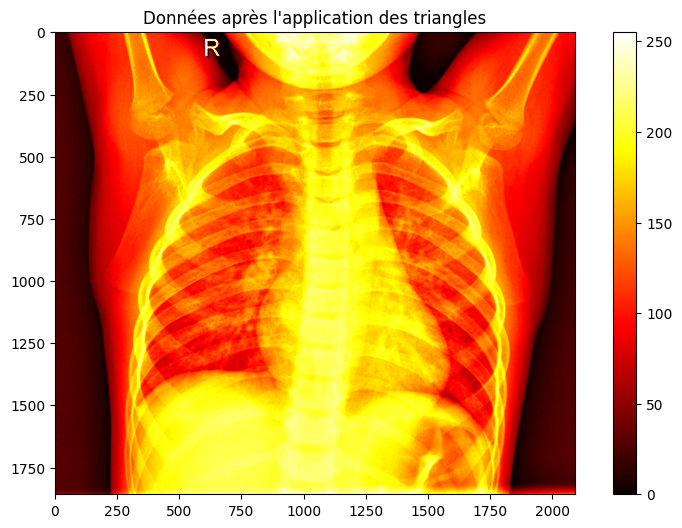

In [10]:
standard_width = 2000
standard_height = 1465

img_resized = image_gray.resize((standard_width, standard_height), Image.LANCZOS)
image_array = np.array(image_gray)
plt.figure(figsize=(10, 6))
plt.imshow(image_array, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class ImageToArrayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_images = []
        for image in X:
            image = image.resize((2000,1457), Image.LANCZOS)
            image_gray = image.convert('L')
            image_array = np.array(image_gray)
            transformed_images.append(image_array)

        return np.array(transformed_images)
    

class MaskSeuilTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='baseline'):
        self.strategy = strategy

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        transformed_images = []
        mask = []

        if self.strategy == 'baseline':
            mask = np.loadtxt("../../datasets/chest_Xray/local_test/_processed_resize/data_mask_seuil.csv", delimiter=",") 
        elif self.strategy == 'geometry':
            mask = np.loadtxt("../../datasets/chest_Xray/local_test/_processed_resize/data_mask_triangle.csv", delimiter=",") 
        elif self.strategy == 'combined':
            mask = np.loadtxt("../../datasets/chest_Xray/local_test/_processed_resize/data_mask_triangle_seuil.csv", delimiter=",") 
        else:
            raise ValueError("Unsupported strategy")

        for array_image in X:
            masked_image_array = np.where(mask == 1, array_image, 0)
            transformed_images.append(masked_image_array)
            
        return np.array(transformed_images)
    

pipeline = Pipeline([
    ('image_to_array', ImageToArrayTransformer()),
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
])




# Fit and transform data
X_train_transformed = pipeline.fit_transform(dataset["train"][:25]["image"])
    

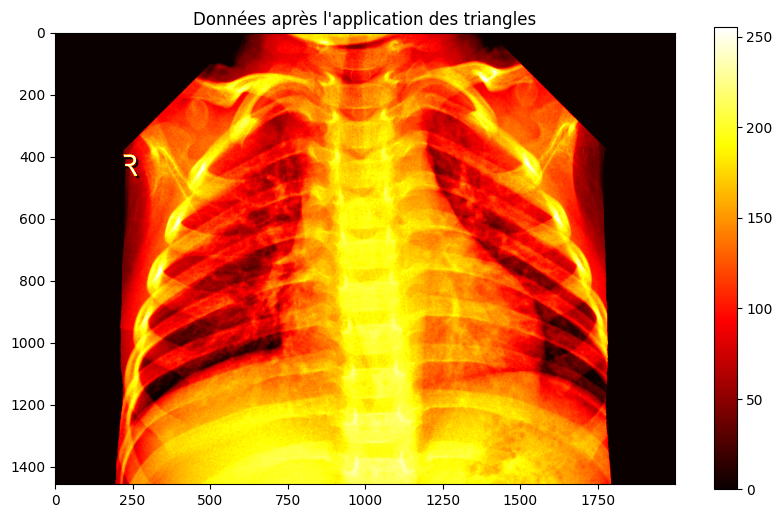

In [12]:
X_train_transformed[1]


image_array = np.array(X_train_transformed[4])
plt.figure(figsize=(10, 6))
plt.imshow(image_array, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()

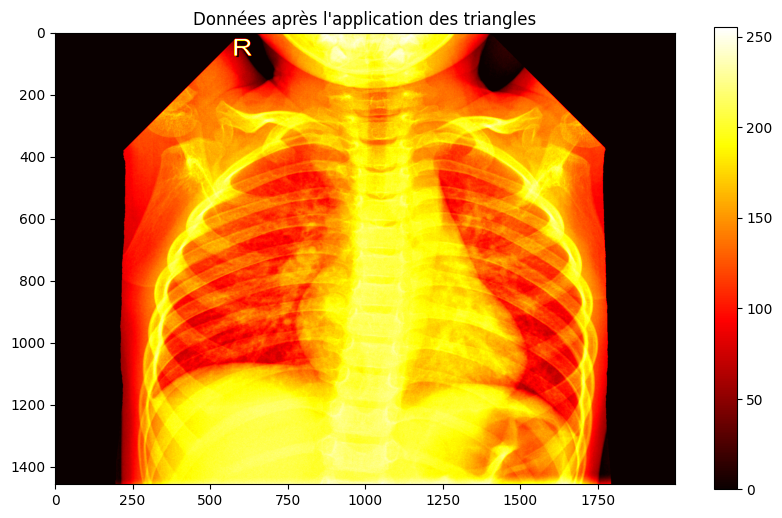

In [51]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier


pipeline = Pipeline([
    ('image_to_array', ImageToArrayTransformer()),
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('flatten', FunctionTransformer(lambda x: np.reshape(x, (x.shape[0], -1)))),
])

nbelemt = 1

result = pipeline.fit_transform(dataset["train"][:nbelemt]["image"])

result = result.reshape(1457, 2000)

plt.figure(figsize=(10, 6))
plt.imshow(result, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()


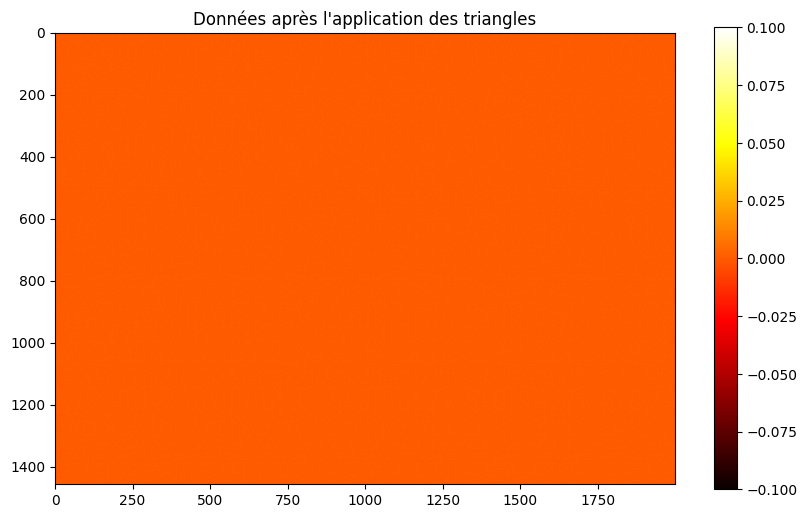

In [52]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier


pipeline = Pipeline([
    ('image_to_array', ImageToArrayTransformer()),
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('flatten', FunctionTransformer(lambda x: np.reshape(x, (x.shape[0], -1)))),
    ('std_scaler', StandardScaler())
])

nbelemt = 1

result = pipeline.fit_transform(dataset["train"][:nbelemt]["image"])

result = result.reshape(1457, 2000)

plt.figure(figsize=(10, 6))
plt.imshow(result, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()

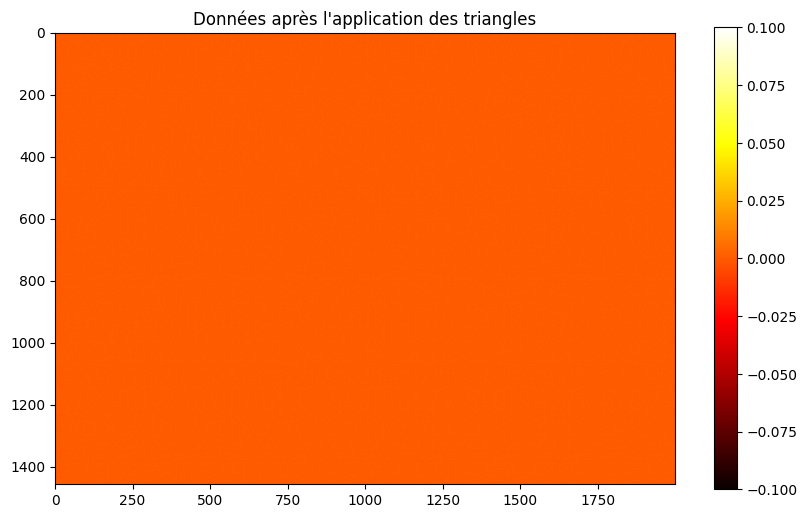

In [57]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline([
    ('image_to_array', ImageToArrayTransformer()),
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('flatten', FunctionTransformer(lambda x: np.reshape(x, (x.shape[0], -1)))),
    ('std_scaler', MinMaxScaler())
])

nbelemt = 1

result = pipeline.fit_transform(dataset["train"][:nbelemt]["image"])

result = result.reshape(1457, 2000)

plt.figure(figsize=(10, 6))
plt.imshow(result, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()

In [55]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier


pipeline = Pipeline([
    ('image_to_array', ImageToArrayTransformer()),
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('flatten', FunctionTransformer(lambda x: np.reshape(x, (x.shape[0], -1)))),
    ('kn', KNeighborsClassifier(n_neighbors=3))

])

nbelemt = 100

pipeline.fit(dataset["train"][:nbelemt]["image"], dataset["train"][:nbelemt]["label"])

pipeline.score(dataset["test"][:nbelemt]["image"], dataset["test"][:nbelemt]["label"])

1.0